## Linear Regression

A simple regression technique that has multiple variants. It is one of the most interpretable and easy machine learning techniques to understand and implement

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

### Simple Linear Regression

Technique which has only one independant variable

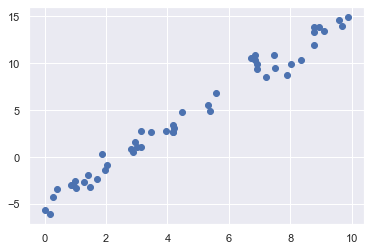

In [2]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

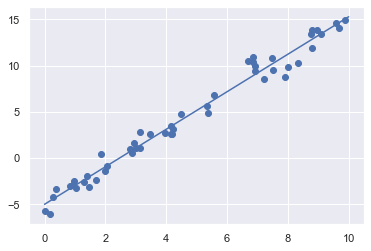

In [5]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)

In [10]:
print("Model slope: ", model.coef_[0])
print("Model intercept: ", model.intercept_)

Model slope:  2.027208810360695
Model intercept:  -4.998577085553202


### Multiple Linear Regression

Regression technique in which there is more than one independant variable

In [12]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2, 1])

In [17]:
model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5000000000000127
[ 1.5 -2.   1. ]


### Polynomial basis functions

In this technique, the independant variable might be projected to higher degrees to give them the ability to the fit more complex patterns

In [19]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

In [20]:
from sklearn.pipeline import make_pipeline 
poly_model = make_pipeline(PolynomialFeatures(7),
                          LinearRegression())

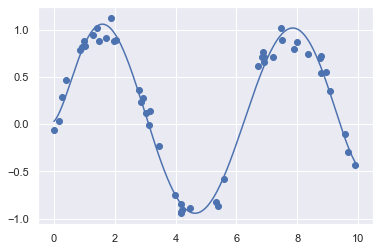

In [21]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)

In [41]:
gauss_model = make_pipeline(GaussianFeatures(20),
                               LinearRegression())

(0, 10)

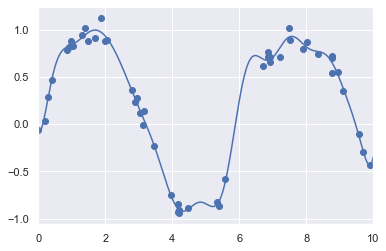

In [43]:
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])
    
plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10)

(-1.5, 1.5)

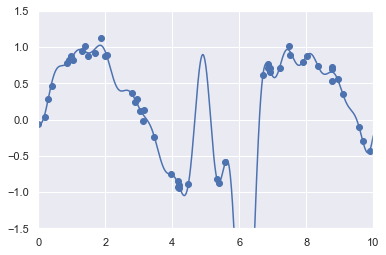

In [44]:
model = make_pipeline(GaussianFeatures(30),
                     LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5)

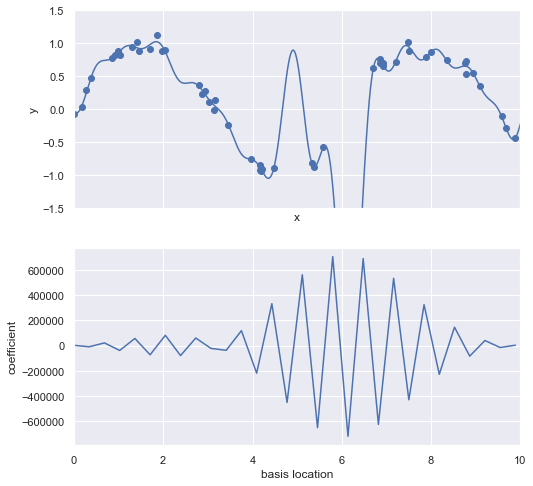

In [47]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True, figsize=(8,8))
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)
    
    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

### Ridge Regression (L2 Regularization)

Also called Tikhonov regularization. It penalizes the model coefficients with the sum of squares of model coefficients(in the case of linear regression). An advantage of the ridge regression model is that it can be computed easily without a lot of extra computational cost

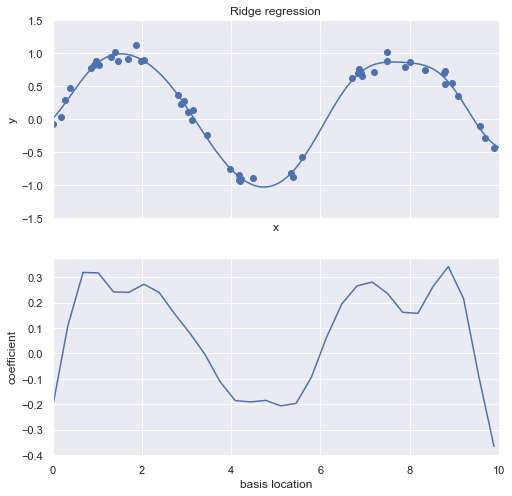

In [52]:
from sklearn.linear_model import Ridge

model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge regression')

### Lasso regression(L1 regularization)

It penalizes model coefficients with the sum of absolute values

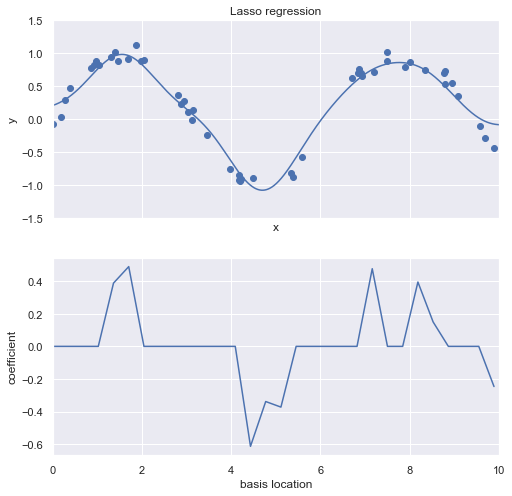

In [54]:
from sklearn.linear_model import Lasso

model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.01))
basis_plot(model, title='Lasso regression')

### Example: Predicting Bicycle traffic

In [57]:
import pandas as pd
counts = pd.read_csv('..//FremontBridge.csv', index_col='Date', parse_dates=True)

In [89]:
weather = pd.read_csv('..//WeatherStation.csv', index_col='DATE', parse_dates=True)

In [65]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']]

In [70]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(len(days)):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [72]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2020')

In [76]:
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

(8, 17)

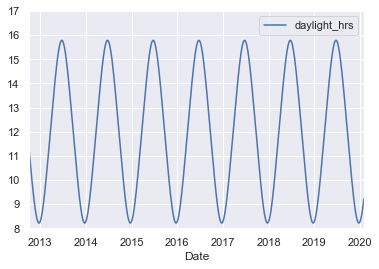

In [80]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

In [95]:
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [99]:
daily.dropna(inplace=True)

In [100]:
daily

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.000000,0.560,1.0
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.000000,0.565,1.0
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.000000,0.595,1.0
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.000000,0.605,1.0
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.000000,0.605,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28,1676.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.245532,0.000000,0.440,1.0
2019-12-29,1846.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.254701,0.000039,0.455,0.0
2019-12-30,3606.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.265207,0.000157,0.455,0.0


In [104]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [105]:
daily

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.000000,0.560,1.0,0.000000
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.000000,0.565,1.0,0.002740
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.000000,0.595,1.0,0.005479
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.000000,0.605,1.0,0.008219
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.000000,0.605,1.0,0.010959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28,1676.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.245532,0.000000,0.440,1.0,7.238356
2019-12-29,1846.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.254701,0.000039,0.455,0.0,7.241096
2019-12-30,3606.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.265207,0.000157,0.455,0.0,7.243836


In [106]:
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

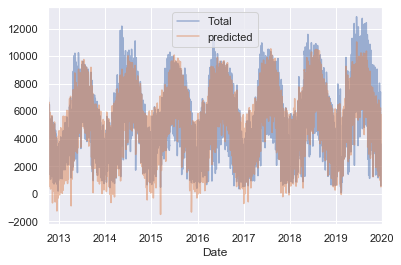

In [107]:
daily[['Total', 'predicted']].plot(alpha=0.5);

In [108]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              -1650.334620
Tue              -1429.555903
Wed              -1487.746374
Thu              -1739.078920
Fri              -2417.367166
Sat              -5218.320320
Sun              -5397.493208
holiday          -2540.718664
daylight_hrs       205.494808
PRCP           -354229.260851
dry day           1053.631585
Temp (C)          8938.339038
annual             161.389246
dtype: float64

In [109]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [110]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

                effect    error
Mon            -1650.0    133.0
Tue            -1430.0    137.0
Wed            -1488.0    134.0
Thu            -1739.0    134.0
Fri            -2417.0    130.0
Sat            -5218.0    130.0
Sun            -5397.0    133.0
holiday        -2541.0    204.0
daylight_hrs     205.0     13.0
PRCP         -354229.0  23522.0
dry day         1054.0     50.0
Temp (C)        8938.0    348.0
annual           161.0     11.0
